<div align="right">Ang Kian Hwee 21 April 2020</div>

<h1>Exploratory Data Analysis of South Korea's COVID19 situation</h1>

**20/01/2020 - 07/04/2020**

**Imports and Reading of data**

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import folium 
from folium import plugins
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
%matplotlib inline 

In [399]:
case_df = pd.read_csv(filepath_or_buffer="data/Case.csv")
region_df = pd.read_csv(filepath_or_buffer="data/Region.csv")
patient_info_df = pd.read_csv(filepath_or_buffer="data/PatientInfo.csv")
route_df = pd.read_csv(filepath_or_buffer="data/PatientRoute.csv")

case_df.replace("etc", "Unclassified", inplace=True)
patient_info_df.replace("etc", "Unclassified", inplace=True)

In [400]:
print(case_df.shape)
case_df.head()

(110, 8)


,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,98,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,True,Dongan Church,20,37.592888,127.056766
2,1000003,Seoul,Guro-gu,True,Manmin Central Church,40,37.481059,126.894343
3,1000004,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
4,1000005,Seoul,Seongdong-gu,True,Seongdong-gu APT,13,37.55713,127.0403


In [401]:
print(patient_info_df.shape)
patient_info_df.head()

(3128, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1,nan,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5,male,1987,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1,nan,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6,male,1964,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7,male,1991,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1,nan,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9,female,1992,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


<h3>Time for some juicy insights *slurps*</h3>

**Number of infection/recovery/death over time**

In [402]:
time_df = pd.read_csv("data/Time.csv")
time_df["datetime"] = pd.to_datetime(time_df['date']) # convert to proper datetime object
time_df["days since"] = time_df["datetime"] - dt.datetime.strptime("2020/01/20", '%Y/%m/%d') # get #days since 1st case reported
time_df["days since"] = time_df["days since"].dt.days # convert timedelta days to integer due to plot xticks limitation
time_df.tail()

,date,time,test,negative,confirmed,released,deceased,datetime,days since
74,2020-04-03,0,443273,414303,10062,6021,174,2020-04-03,74
75,2020-04-04,0,455032,424732,10156,6325,177,2020-04-04,75
76,2020-04-05,0,461233,431425,10237,6463,183,2020-04-05,76
77,2020-04-06,0,466804,437225,10284,6598,186,2020-04-06,77
78,2020-04-07,0,477304,446323,10331,6694,192,2020-04-07,78


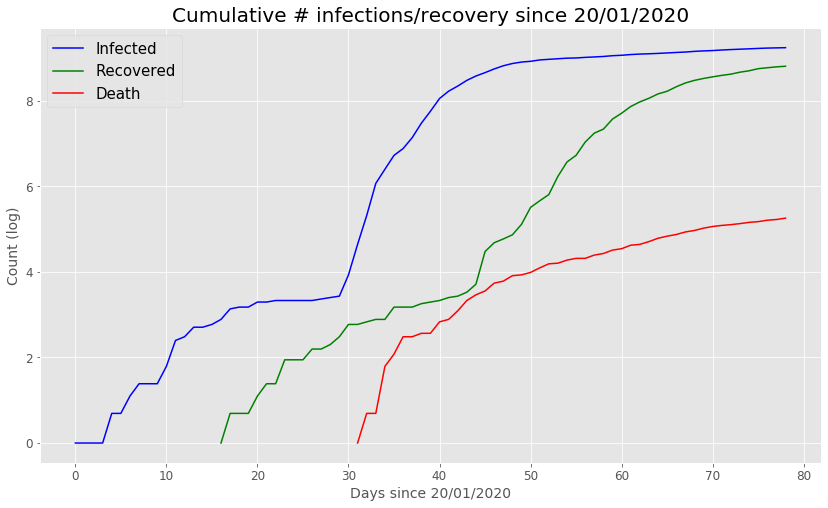

In [403]:
plt.figure(figsize=(14,8))
plt.plot(time_df["days since"], np.log(time_df["confirmed"]), label="Infected", color="blue")
plt.plot(time_df["days since"], np.log(time_df["released"]), label="Recovered", color="green")
plt.plot(time_df["days since"], np.log(time_df["deceased"]), label="Death", color="red")
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Cumulative # infections/recovery since 20/01/2020", size=20)
plt.xlabel("Days since 20/01/2020", size=14)
plt.ylabel("Count (log)", size=14)
plt.legend(prop={"size":15})
plt.show()

<div class="alert alert-info">
We see that the number of infections did not pick up till the 30 day mark where a sharp increase of infections was experience at around day 36 to day 48. From day 48 onwards, the rate of infection started to slow down while still increasing.
<br><br>
The first recovery occured at around day 17 and increased at a steady rate till day 43 where there is a sharp spike in recovered patients.
<br><br>
The first death occured 30 days after the first case appeared with a steep increase till around day 37 where the rate of death increases at a steady rate. The good news is the number of deaths is little compared to the number of infections, with numbers hovering below 200. This implies covid19 does not have a high mortality rate and not lethal (for now).
</div>

**Rate of Spread/Recovery/Death (20/01/2020 - 07/04/2020)**

To calculate the respective rates, I use this formula

rate = (# of cases per day) / (total cases accumulated on 07/04/2020).

In [404]:
# pd.reset_option('display.float_format')
time_df["mortality_rate"] = [round(time_df["deceased"].iloc[i]/time_df["deceased"].iloc[-1], 3) for i in range(time_df.shape[0])]
time_df["recovery_rate"] = [round(time_df["released"].iloc[i]/time_df["released"].iloc[-1], 3) for i in range(time_df.shape[0])]
time_df["spread_rate"] = [round(time_df["confirmed"].iloc[i]/time_df["confirmed"].iloc[-1], 3) for i in range(time_df.shape[0])]
time_df.tail()

,date,time,test,negative,confirmed,released,deceased,datetime,days since,mortality_rate,recovery_rate,spread_rate
74,2020-04-03,0,443273,414303,10062,6021,174,2020-04-03,74,1,1,1
75,2020-04-04,0,455032,424732,10156,6325,177,2020-04-04,75,1,1,1
76,2020-04-05,0,461233,431425,10237,6463,183,2020-04-05,76,1,1,1
77,2020-04-06,0,466804,437225,10284,6598,186,2020-04-06,77,1,1,1
78,2020-04-07,0,477304,446323,10331,6694,192,2020-04-07,78,1,1,1


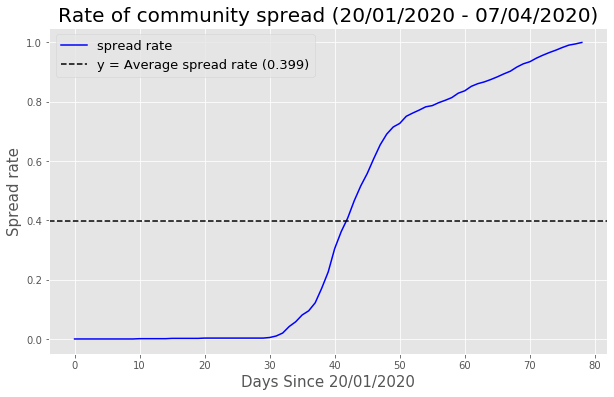

In [405]:
mean_spread_rate = np.mean(time_df['spread_rate'])
plt.figure(figsize=(10,6))
plt.plot(time_df['days since'], time_df['spread_rate'], color="blue")
plt.axhline(mean_spread_rate, linestyle="--", color="black")
plt.legend(['spread rate', 'y = Average spread rate ('+str(round(mean_spread_rate,3)) + ')'], prop={'size': 13})
plt.title("Rate of community spread (20/01/2020 - 07/04/2020)", size=20)
plt.xlabel('Days Since 20/01/2020', size=15)
plt.ylabel('Spread rate', size=15)
plt.show()

<div class="alert alert-info">
The average infection rate is about 0.4 or 40 out of 100 people gets infected. The public will need to be vigilant and observe proper hygiene to curb the spread among the community. Government will need prep more healthcare resources to tackle the raising rate of infection.
</div>

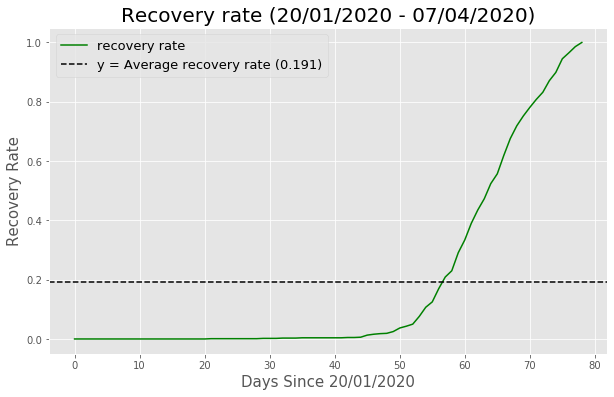

In [406]:
mean_recovery_rate = np.mean(time_df['recovery_rate'])
plt.figure(figsize=(10,6))
plt.plot(time_df['days since'], time_df['recovery_rate'], color="green")
plt.axhline(mean_recovery_rate, linestyle="--", color="black")
plt.legend(['recovery rate', 'y = Average recovery rate ('+str(round(mean_recovery_rate,3)) + ')'], prop={'size': 13})
plt.title("Recovery rate (20/01/2020 - 07/04/2020)", size=20)
plt.xlabel('Days Since 20/01/2020', size=15)
plt.ylabel('Recovery Rate', size=15)
plt.show()

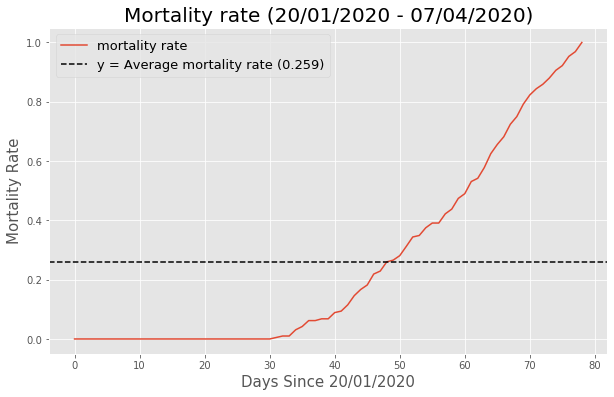

In [407]:
mean_mortal_rate = np.mean(time_df['mortality_rate'])
plt.figure(figsize=(10,6))
plt.plot(time_df['days since'], time_df['mortality_rate'])
plt.axhline(mean_mortal_rate, linestyle="--", color="black")
plt.legend(['mortality rate', 'y = Average mortality rate ('+str(round(mean_mortal_rate,3)) + ')'], prop={'size': 13})
plt.title("Mortality rate (20/01/2020 - 07/04/2020)", size=20)
plt.xlabel('Days Since 20/01/2020', size=15)
plt.ylabel('Mortality Rate', size=15)
plt.show()

<div class="alert alert-info">
When we looked deeper into the actual rates, we see that the recovery rate is the lowest among the 3 rates. This means patients are not recovering as fast unlike the common flu. Death rate is worth noticing as it is relatively higher than recovery. The average death rate is 0.256, or <b>26 out of 100</b> people die. The cause of the deaths are unknown but we will assume it to be due to COVID19. 

<div></div>
<br>
Despite that, we notice that recovery rate has a steeper gradient compared to death rate. It will be good news if such recovery rate keep up as more cases are discovered.
</div>

**Most common cause of infection**

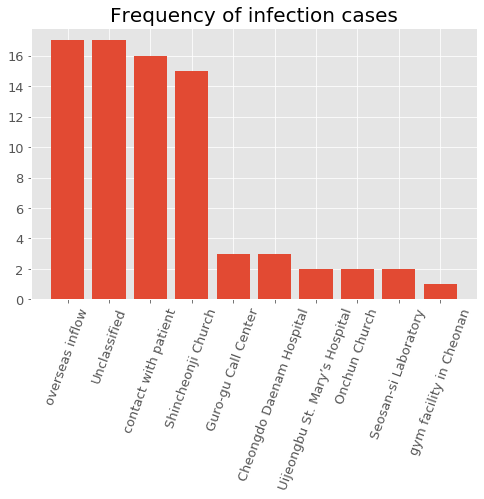

In [408]:
# cases per infection case
infection_cases_count = pd.DataFrame(case_df.groupby("infection_case").size(), columns=["count"]).sort_values(by="count", ascending=False)
infection_cases_count.reset_index(drop=False, inplace=True)
# infection_cases_count.iloc[1, 0] = "Untraced"
plt.figure(figsize=(8,5)) # row, height
plt.bar(infection_cases_count["infection_case"][:10], infection_cases_count["count"][:10])
plt.title("Frequency of infection cases", size=20)
plt.xticks(rotation=70, size=13)
plt.yticks(size=13)
plt.show()

In [409]:
num_of_cases_per_incident = case_df.groupby("infection_case").size().sort_values(ascending=False)[:10].to_dict()
pd.DataFrame(num_of_cases_per_incident.values(), index=num_of_cases_per_incident.keys(), columns=["Total Frequency"])

,Total Frequency
overseas inflow,17
Unclassified,17
contact with patient,16
Shincheonji Church,15
Cheongdo Daenam Hospital,3
Guro-gu Call Center,3
Uijeongbu St. Mary’s Hospital,2
Seosan-si Laboratory,2
Onchun Church,2
Geochang-gun Woongyang-myeon,1


<div class="alert alert-info">
    Most infections come from <b>imported cases (overseas)</b>, <b>local transmission</b> (linked and untraceable) and the <b>Shincheonji Church</b> incident.
</div>

**Number of infections by cause/cluster**

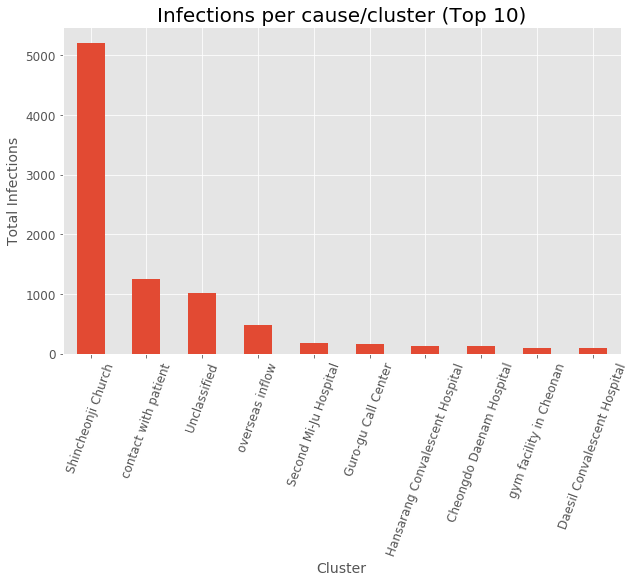

In [410]:
case_df.groupby("infection_case")["confirmed"].sum().sort_values(ascending=False)[:10].plot(kind="bar", figsize=(10,6))
plt.xticks(rotation=70)
plt.title("Infections per cause/cluster (Top 10)", size=20)
plt.xlabel("Cluster",size=14)
plt.ylabel("Total Infections", size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [411]:
# top 10 clusters of infection
number_of_infections = pd.DataFrame(case_df.groupby("infection_case")["confirmed"].sum().sort_values(ascending=False)[:10])
number_of_infections.reset_index(inplace=True)
number_of_infections

,infection_case,confirmed
0,Shincheonji Church,5209
1,contact with patient,1253
2,Unclassified,1025
3,overseas inflow,478
4,Second Mi-Ju Hospital,185
5,Guro-gu Call Center,166
6,Hansarang Convalescent Hospital,126
7,Cheongdo Daenam Hospital,123
8,gym facility in Cheonan,103
9,Daesil Convalescent Hospital,98


In [412]:
number_of_infections = pd.DataFrame(case_df.groupby("infection_case")["confirmed"].sum().sort_values(ascending=False))
number_of_infections.reset_index(inplace=True)
# number_of_infections[number_of_infections["infection_case"]!="Shincheonji Church"].sum().confirmed

print("Total number of infections excluding Shincheonji Church: %d" 
      %number_of_infections[number_of_infections["infection_case"]!="Shincheonji Church"].sum().confirmed)

Total number of infections excluding Shincheonji Church: 4250


<div class="alert alert-info">
    The largest cluster, <i>Shincheonji Church</i> is more than the total sum of all the other clusters (5209 vs 4250). Where is majority of such incidents taking place at?
</div>

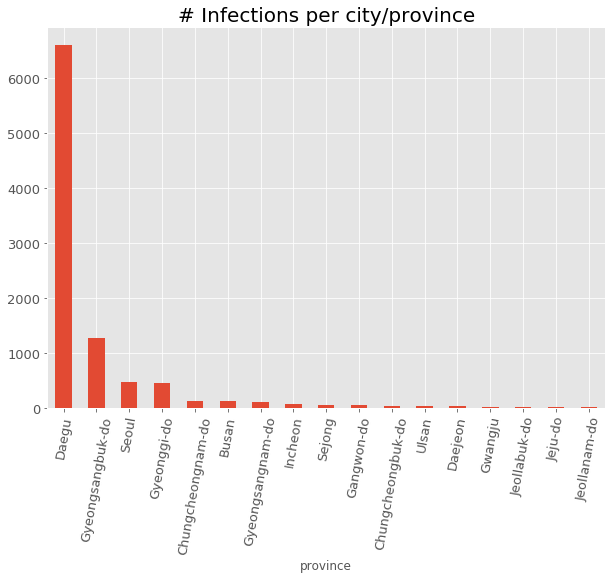

In [413]:
case_df.groupby("province").sum()["confirmed"].sort_values(ascending=False).to_frame().plot(kind="bar", 
                                                                                            figsize=(10,7), 
                                                                                            legend=False)
plt.title("# Infections per city/province", size=20)
plt.xticks(size=13, rotation=80)
plt.yticks(size=13)
plt.show()

Daegu has the highest number of infections, <b>more than double</b> that of all cities/provinces combined!

In [414]:
# breakdown of Shincheonji Church infections into cities
case_df[case_df["infection_case"]=="Shincheonji Church"].groupby("province")["confirmed"]\
.sum()\
.sort_values(ascending=False)\
.to_frame()

,confirmed
province,
Daegu,4508
Gyeongsangbuk-do,566
Gyeongsangnam-do,32
Gyeonggi-do,29
Gangwon-do,17
Ulsan,16
Busan,12
Gwangju,9
Seoul,7


<div class="alert alert-info">
Daegu has the highest number of Shincheonji Church cases. This tells us that Daegu is ground zero for this cluster.
</div>

**Patients' Contact Network**

Lets look at how many people came into contact with people from the Shincheongji Church

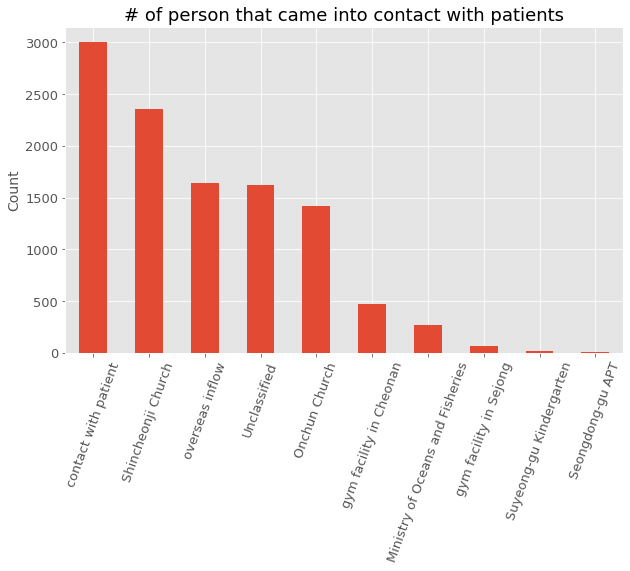

In [415]:
# Lets look at how many people came into conact with people from the Shincheongji Church (top 10 infections)
num_contacts = patient_info_df.groupby("infection_case").sum()["contact_number"].sort_values(0, ascending=False)[:10].to_dict()
ax = pd.DataFrame(num_contacts.values(), index=num_contacts.keys(), columns=["count"]).plot(kind="bar", 
                                                                                       legend=False, 
                                                                                       figsize=(10,6)
                                                                                          )
ax.set_title("# of person that came into contact with patients", size=18)
ax.set_ylabel("Count", size=14)
ax.tick_params("x",labelsize=13, labelrotation=70)
ax.tick_params("y",labelsize=13)

**How many people are infected by each patient?**

In [416]:
# How many people are infected by each patient? (top 10)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
num_infected_by = patient_info_df.groupby("infected_by").size().sort_values(0, ascending=False).dropna().to_frame().reset_index()
# num_infected_by = pd.DataFrame(num_infected_by.values(), index=num_infected_by.keys(), columns=["count"]).head(10)
num_infected_by.head(10)

,infected_by,0
0,2000000205,51
1,4100000008,27
2,2000000167,24
3,4100000006,21
4,2000000309,21
5,1000000125,18
6,1200000031,17
7,2000000508,15
8,2000000125,11
9,2000000476,9


And these patients are from...

In [417]:
num_infected_by.columns = ["patient_id", "total_infected"]
patient_info_df_combine = patient_info_df.merge(num_infected_by, on="patient_id")

patient_info_df_combine[patient_info_df_combine.patient_id.isin(num_infected_by.patient_id[:10])]\
[["patient_id", "province", "city", "infection_case", "contact_number", "total_infected"]]\
.sort_values("total_infected", ascending=False)

,patient_id,province,city,infection_case,contact_number,total_infected
182,2000000205,Gyeonggi-do,Seongnam-si,contact with patient,8,51
232,4100000008,Chungcheongnam-do,Cheonan-si,gym facility in Cheonan,130,27
177,2000000167,Gyeonggi-do,Bucheon-si,contact with patient,nan,24
198,2000000309,Gyeonggi-do,Gunpo-si,Unclassified,nan,21
230,4100000006,Chungcheongnam-do,Asan-si,contact with patient,41,21
28,1000000125,Seoul,Nowon-gu,Guro-gu Call Center,nan,18
102,1200000031,Daegu,NaN,Shincheonji Church,1160,17
222,2000000508,Gyeonggi-do,Pyeongtaek-si,overseas inflow,nan,15
169,2000000125,Gyeonggi-do,Seongnam-si,Unclassified,3,11
219,2000000476,Gyeonggi-do,Uijeongbu-si,Unclassified,nan,9


<div class="alert alert-info">
    Bringing your attention to the <i>contact_number</i> and <i>total_infected</i> columns, we observe the following:

<u>Patient 2000000205</u>
- Has the highest number of infections
- Least number of contacts 

<u>Patient 1200000031</u>
- Highest number of contacts
- Has lesser than half the number of infections (compared to the patient 2000000205)

<div></div><br>
This could be either because the data is not complete or there's some discrepancies in the data.
</div>

**Let's take a look at the travel history of these patients.**

In [418]:
# see patient 1200000031 travel history to see how did the contact number rise so high (use folium)
def make_polygon_time(route_df, patient_df, id_num, coords='', zoom=12):
    print(f'Where {id_num}th patient went for several days')
    
    
    # set the zoom point
    if coords!="":
        m = folium.Map([coords[0], coords[1]], zoom_start=zoom)
    else:
        m = folium.Map([36.5, 128], zoom_start=7.5)
    
    id_filter = route_df.query('patient_id == @id_num')
    id_filter['timestamp'] = [date+'T00:00:00' for date in id_filter['date']]
    id_filter_shift = id_filter.shift(-1) 
    
    # set the icon on Incheon airport and gimpo airport
    icon_plane1 = plugins.BeautifyIcon(icon='plane', order_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    icon_plane2 = plugins.BeautifyIcon(icon='plane', border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    folium.Marker(location=[37.4692, 126.451], popup='incheon airport', icon=icon_plane1).add_to(m)
    folium.Marker(location=[37.558808, 126.794458], popup='gimpo airport', icon=icon_plane2).add_to(m)
    
    # mark the cities - Seoul / Busan / Daegu / Daejeon / Gwangju / Incheon / Ulsan
    folium.CircleMarker(location=[37.532600, 127.024612], popup="Seoul", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[35.166668, 129.066666], popup="Busan", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[35.874008, 128.600540], popup="Daegu", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[36.351002, 127.385002], popup="Daejeon", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[35.166668, 126.916664], popup="Gwangju", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[37.456257, 126.705208], popup="Incheon", color="green", radius=5).add_to(m)
    folium.CircleMarker(location=[35.549999, 129.316666], popup="Ulsan", color="green", radius=5).add_to(m)
    
    # mark hospital
    icon_hospital1 = plugins.BeautifyIcon(icon='h-square', border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    icon_hospital2 = plugins.BeautifyIcon(icon='h-square', border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    icon_hospital3 = plugins.BeautifyIcon(icon='h-square', border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    folium.Marker(location=[35.8583905, 128.6352138], popup='Suseong-gu hospital', icon=icon_hospital1).add_to(m)
    folium.Marker(location=[35.859603, 128.540617], popup='Seo-gu hospital', icon=icon_hospital2).add_to(m)
    folium.Marker(location=[36.8134905, 127.1391693], popup='Cheonan-si hospital', icon=icon_hospital3).add_to(m)
    
    # mark Shincheonji church
    icon_church1 = plugins.BeautifyIcon(number="SC", border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    icon_church2 = plugins.BeautifyIcon(number="C", border_color='#b3334f', text_color='#b3334f', icon_shape='circle')
    folium.Marker(location=[35.8412055, 128.5982428], popup='Shincheonji church', icon=icon_church1).add_to(m)
    folium.Marker(location=[36.7296391, 127.2600261], popup='church', icon=icon_church2).add_to(m)
    
    # add the fullscreen utility. if you don't need, it's ok to remark the line :)
    plugins.Fullscreen( position='topright', title='Click to expand', title_cancel='Click to exit', force_separate_button=True ).add_to(m)

    
    lines = []
    for lon, lat, time, lon_s, lat_s, time_s in zip(id_filter['longitude'],
                                                    id_filter['latitude'],
                                                    id_filter['timestamp'], 
                                                    id_filter_shift['longitude'],
                                                    id_filter_shift['latitude'],
                                                    id_filter_shift['timestamp']):
        temp_dict = {}
        temp_dict['coordinates'] = [[lon,lat], [lon_s,lat_s]]
        temp_dict['dates'] = [time,time_s]
        temp_dict['color'] = 'red'

        lines += [temp_dict]

    del lines[-1]

    features = [ {'type': 'Feature', 
                  'geometry': {
                      'type': 'LineString', 
                      'coordinates': line['coordinates'],
                  }, 
                  'properties': {
                      'times': line['dates'], 
                      'style': {'color': line['color'], 
                                'weight': line['weight'] if 'weight' in line else 5 } } } for line in lines ] 

    plugins.TimestampedGeoJson({'type': 'FeatureCollection', 'features': features, },
                               period='PT6H', # time lapse of 6 hours per second
                               add_last_point=True, # to show ending point (in case point disappears due to duration param set)
                               transition_time=200).add_to(m) # fps: higher value=faster fps

    return m

In [419]:
make_polygon_time(route_df, patient_info_df, 1200000031, [35.874008, 128.600540])

Where 1200000031th patient went for several days


<div class="alert alert-info">
Patient 1200000031 has travelled mostly around Daegu area. Travel history shows that she has been to the hospital first then to church, and finally back to the hospital. Without her medical records, the hypothesis is that she was still sick when she left the 1st hospital. <br><b>The large contact number is probably attributed to the church gathering and the other places she has been prior to the second visit to the hospital.</b>
</div>

In [420]:
make_polygon_time(route_df, patient_info_df, 4100000006, [36.8116846, 127.1090056], 12)

Where 4100000006th patient went for several days


In [421]:
make_polygon_time(route_df, patient_info_df, 4100000008, [37.3052039, 126.8608219], 9.4)

Where 4100000008th patient went for several days


Unfortunately there is no travel route data of patient 2000000205.

<div class="alert alert-info">
However for patients 4100000006 and 4100000008, their travel history are <b>away from the main city areas</b> like Seoul and Incheon. 
</div>

<h1>Conclusion</h1>

<div class="alert alert-success">
The following discoveries were made from this EDA: 
    
- Number of infections spiked after 30 days from first case of COVID19 in south korea but is reaching a pleateu, probably due to the hygenie habits of koreans and government efforts. <br><br>
    
- Although the number of recoveries is greater than number of deaths, the rate of recovery is slower than rate of deaths. This is something which WHO needs to address as COVID19 may turn out deadly. <br><br>
    
- Located in Daegu, Shincheonji church cluster has the highest number of infections. <br><br>
    
- Patient 1200000031, aka 'Super Spreader' has travelled mostly around Daegu and has been to many places including a church gathering even though she was still sick. <br><br>
    
- Other patients who have lesser number of contacts and infections travelled outside of main city areas which probably contributed to the lower number. <br><br>
    
I thank you for reading up till this point. Hope it was an interesting read for you :)
</div>

~ The End ~